# Mislabeled data detection - RoBERTa-MRPC

This notebook demonstrates how to efficiently compute the influence functions using DataInf, showing its application to **mislabeled data detection** tasks.

- Model: Robert-large (https://arxiv.org/abs/1907.11692; pretrained with BOOKCORPUS, WIKIPEDIA, CC-NEWS, to name a few)
- Fine-tuning dataset: GLUE-mrpc
    - What is MRPC? The Microsoft Research Paraphrase Corpus (Dolan & Brockett, 2005) is a corpus of sentence pairs automatically extracted from online news sources, with human annotations for whether the sentences in the pair are semantically equivalent.

References
- https://github.com/huggingface/peft/blob/main/examples/sequence_classification/LoRA.ipynb
- DataInf is available at this [ArXiv link](https://arxiv.org/abs/2310.00902).

In [1]:
import sys
sys.path.append('../src')
from dataloader import create_dataloaders, load_noisy_dataset_by_task
from lora_model import LORAEngine
from influence import IFEngine

import numpy as np
from sklearn.metrics import roc_auc_score
from matplotlib import pyplot as plt
import os
from datasets import load_dataset

## Set up hyperparameters and LoRA models

In [2]:
model_name_or_path="roberta-large"
task="sst2"
noise_ratio=0.2
batch_size=32
target_modules=["value"]
device="cuda:4"
num_epochs=10
lr=3e-4

In [3]:
np.random.seed(42)
glue_datasets = load_dataset("glue", task) 
n_train = len(glue_datasets['train'])
n_val = len(glue_datasets['validation'])
if n_train > 4500 and n_val > 500:
    new_n_train_list = np.random.choice(n_train, 4500, replace=False)
    new_n_val_list = np.random.choice(n_val, 500, replace=False)
    glue_datasets['train'] = glue_datasets['train'].select(new_n_train_list)
    glue_datasets['validation'] = glue_datasets['validation'].select(new_n_val_list)

In [5]:
# glue_datasets['train']['question'][0]

In [28]:
# glue_datasets['train']['sentence'][0]

"Mission work in Samoa had begun in late 1830 by John Williams, of the London Missionary Society arriving in Sapapali'i from The Cook Islands and Tahiti."

In [27]:
# glue_datasets['train']['label'][0]

1

In [6]:
mrpc_02_noise, noise_added=load_noisy_dataset_by_task(task="sst2", noise_ratio=0.2)

Map:   0%|          | 0/4500 [00:00<?, ? examples/s]

In [7]:
mrpc_02_noise

DatasetDict({
    train: Dataset({
        features: ['sentence', 'label', 'idx'],
        num_rows: 4500
    })
    validation: Dataset({
        features: ['sentence', 'label', 'idx'],
        num_rows: 500
    })
    test: Dataset({
        features: ['sentence', 'label', 'idx'],
        num_rows: 1821
    })
})

In [8]:
data_train=mrpc_02_noise['train']
data_test=mrpc_02_noise['validation']

In [9]:
data_train

Dataset({
    features: ['sentence', 'label', 'idx'],
    num_rows: 4500
})

In [10]:
data_test

Dataset({
    features: ['sentence', 'label', 'idx'],
    num_rows: 500
})

In [13]:
data_train['sentence']

["with outtakes in which most of the characters forget their lines and just utter ` uhhh , ' which is better than most of the writing in the movie ",
 'enigma is well-made ',
 'is ) so stoked to make an important film about human infidelity and happenstance that he tosses a kitchen sink onto a story already overladen with plot conceits . ',
 'the closest thing to the experience of space travel ',
 'lose their luster ',
 'reopens an interesting controversy and ',
 'competent , unpretentious entertainment ',
 'an effective portrait of a life in stasis ',
 'transcendent performance ',
 'so vivid ',
 "' rip-off ",
 'its hackneyed and meanspirited storyline with cardboard characters and performers ',
 'a rollicking good time for the most part ',
 'not funny performers ',
 'who has reached puberty actually finding the characters in slackers or their antics amusing , let alone funny ',
 'entering ',
 'and revolutionary spirit ',
 'of deft and subtle poetry ',
 'a buoyant delivery ',
 'is wort

In [12]:
data_train['sentence']

["with outtakes in which most of the characters forget their lines and just utter ` uhhh , ' which is better than most of the writing in the movie ",
 'enigma is well-made ',
 'is ) so stoked to make an important film about human infidelity and happenstance that he tosses a kitchen sink onto a story already overladen with plot conceits . ',
 'the closest thing to the experience of space travel ',
 'lose their luster ',
 'reopens an interesting controversy and ',
 'competent , unpretentious entertainment ',
 'an effective portrait of a life in stasis ',
 'transcendent performance ',
 'so vivid ',
 "' rip-off ",
 'its hackneyed and meanspirited storyline with cardboard characters and performers ',
 'a rollicking good time for the most part ',
 'not funny performers ',
 'who has reached puberty actually finding the characters in slackers or their antics amusing , let alone funny ',
 'entering ',
 'and revolutionary spirit ',
 'of deft and subtle poetry ',
 'a buoyant delivery ',
 'is wort

In [14]:
data_test['label']

[1,
 1,
 1,
 0,
 1,
 0,
 0,
 1,
 1,
 1,
 0,
 0,
 1,
 0,
 0,
 0,
 1,
 0,
 0,
 1,
 1,
 1,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 1,
 1,
 0,
 1,
 0,
 1,
 0,
 0,
 1,
 1,
 0,
 0,
 0,
 1,
 0,
 0,
 1,
 0,
 1,
 0,
 0,
 1,
 1,
 1,
 0,
 0,
 0,
 1,
 1,
 1,
 1,
 0,
 1,
 0,
 1,
 1,
 0,
 1,
 1,
 0,
 1,
 1,
 1,
 0,
 0,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 0,
 0,
 1,
 0,
 0,
 1,
 1,
 0,
 0,
 1,
 1,
 0,
 0,
 1,
 1,
 0,
 1,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 1,
 1,
 1,
 0,
 1,
 0,
 1,
 0,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 0,
 0,
 1,
 0,
 0,
 1,
 0,
 0,
 1,
 1,
 0,
 0,
 1,
 0,
 1,
 0,
 0,
 0,
 1,
 0,
 0,
 1,
 0,
 0,
 1,
 0,
 0,
 1,
 0,
 0,
 1,
 0,
 0,
 1,
 0,
 1,
 0,
 0,
 1,
 1,
 1,
 1,
 0,
 0,
 1,
 1,
 0,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 0,
 1,
 0,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 1,
 1,
 1,
 0,
 1,
 0,
 0,
 0,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 0,
 1,
 0,
 1,
 1,
 1,
 1,
 0,
 1,
 0,
 1,
 0,
 0,
 1,
 1,
 1,
 0,
 0,
 1,


In [15]:
sorted(noise_added)

[12,
 14,
 19,
 21,
 38,
 40,
 43,
 44,
 50,
 57,
 63,
 64,
 71,
 75,
 80,
 81,
 90,
 92,
 101,
 104,
 105,
 116,
 127,
 128,
 160,
 165,
 170,
 173,
 185,
 188,
 192,
 193,
 194,
 196,
 199,
 201,
 212,
 213,
 233,
 236,
 238,
 241,
 242,
 243,
 250,
 260,
 267,
 269,
 270,
 275,
 276,
 285,
 292,
 294,
 296,
 308,
 312,
 318,
 325,
 326,
 341,
 342,
 348,
 350,
 351,
 362,
 371,
 372,
 374,
 377,
 393,
 403,
 417,
 423,
 426,
 427,
 437,
 445,
 446,
 450,
 453,
 454,
 460,
 469,
 477,
 491,
 498,
 511,
 517,
 520,
 524,
 528,
 531,
 537,
 544,
 545,
 547,
 548,
 551,
 559,
 560,
 564,
 574,
 576,
 577,
 583,
 584,
 585,
 586,
 588,
 595,
 597,
 598,
 613,
 618,
 621,
 622,
 631,
 632,
 633,
 635,
 639,
 641,
 643,
 648,
 652,
 657,
 661,
 672,
 675,
 679,
 684,
 694,
 696,
 698,
 700,
 703,
 721,
 724,
 725,
 731,
 734,
 771,
 772,
 780,
 790,
 796,
 813,
 814,
 820,
 832,
 835,
 839,
 855,
 857,
 859,
 865,
 873,
 877,
 879,
 891,
 894,
 897,
 898,
 901,
 917,
 929,
 937,
 939,
 943

In [16]:
data_train.save_to_disk('../datasets/sst2-0.2-train.hf')
data_test.save_to_disk('../datasets/sst2-0.2-test.hf')

Saving the dataset (0/1 shards):   0%|          | 0/4500 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/500 [00:00<?, ? examples/s]

In [29]:
dataloader_outputs = create_dataloaders(model_name_or_path=model_name_or_path,
                                           task=task,
                                           noise_ratio=noise_ratio,
                                           batch_size=batch_size)
check_train_dataloader, check_eval_dataloader, check_noise_index, check_tokenized_datasets, check_collate_fn = dataloader_outputs

/home/haskari/miniconda3/envs/influence/lib/python3.11/site-packages/huggingface_hub/file_download.py:1150: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Map:   0%|          | 0/4500 [00:00<?, ? examples/s]

Map:   0%|          | 0/4500 [00:00<?, ? examples/s]

Map:   0%|          | 0/500 [00:00<?, ? examples/s]

In [30]:
len(check_train_dataloader)

141

In [32]:
size=int(0.2*4500)
size

900

In [10]:
# fine-tuning models
dataloader_outputs = create_dataloaders(model_name_or_path=model_name_or_path,
                                           task=task,
                                           noise_ratio=noise_ratio,
                                           batch_size=batch_size)
train_dataloader, eval_dataloader, noise_index, tokenized_datasets, collate_fn = dataloader_outputs



lora_engine = LORAEngine(model_name_or_path=model_name_or_path,
                            target_modules=target_modules,
                            train_dataloader=train_dataloader,
                            eval_dataloader=eval_dataloader,
                            device=device,
                            num_epochs=num_epochs,
                            lr=lr,
                            low_rank=8, 
                            task=task)

/home/haskari/miniconda3/envs/influence/lib/python3.11/site-packages/huggingface_hub/file_download.py:1150: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Map:   0%|          | 0/4500 [00:00<?, ? examples/s]

Map:   0%|          | 0/4500 [00:00<?, ? examples/s]

Map:   0%|          | 0/500 [00:00<?, ? examples/s]

## Fine-tune a model

In [11]:
!nvidia-smi

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Tue Sep 24 18:27:52 2024       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 560.35.03              Driver Version: 560.35.03      CUDA Version: 12.6     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA RTX 6000 Ada Gene...    Off |   00000000:03:00.0 Off |                  Off |
| 30%   43C    P0             94W /  300W |   45994MiB /  49140MiB |     18%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [12]:
#os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
#os.environ["CUDA_VISIBLE_DEVICES"] = "4,5,6,7"
lora_engine.build_LORA_model()
lora_engine.train_LORA_model()

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-large and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


trainable params: 1,444,866 || all params: 356,806,660 || trainable%: 0.4049


100%|██████████| 16/16 [00:01<00:00, 11.07it/s]


Epoch 1: {'accuracy': 0.52}


100%|██████████| 16/16 [00:01<00:00, 10.93it/s]


Epoch 2: {'accuracy': 0.664}


100%|██████████| 16/16 [00:01<00:00, 10.73it/s]


Epoch 3: {'accuracy': 0.76}


100%|██████████| 16/16 [00:01<00:00, 10.56it/s]


Epoch 4: {'accuracy': 0.808}


100%|██████████| 16/16 [00:01<00:00, 10.65it/s]


Epoch 5: {'accuracy': 0.83}


100%|██████████| 16/16 [00:01<00:00, 10.49it/s]


Epoch 6: {'accuracy': 0.84}


100%|██████████| 16/16 [00:01<00:00, 10.52it/s]


Epoch 7: {'accuracy': 0.844}


100%|██████████| 16/16 [00:01<00:00, 10.44it/s]


Epoch 8: {'accuracy': 0.868}


100%|██████████| 16/16 [00:01<00:00, 10.47it/s]


Epoch 9: {'accuracy': 0.868}


100%|██████████| 16/16 [00:01<00:00, 10.40it/s]

Epoch 10: {'accuracy': 0.866}


## Compute the gradient
 - Influence function uses the first-order gradient of a loss function. Here we compute gradients using `compute_gradient`
 - `tr_grad_dict` has a nested structure of two Python dictionaries. The outer dictionary has `{an index of the training data: a dictionary of gradients}` and the inner dictionary has `{layer name: gradients}`. The `val_grad_dict` has the same structure but for the validationd data points. 

In [13]:
tr_grad_dict, val_grad_dict = lora_engine.compute_gradient(tokenized_datasets, collate_fn)

100%|██████████| 500/500 [00:36<00:00, 13.58it/s]


## Compute the influence function
 - We compute the inverse Hessian vector product first using `compute_hvps()`. With the argument `compute_accurate=True`, the exact influence function value will be computed. (it may take an hour to compute).

In [14]:
influence_engine = IFEngine()
influence_engine.preprocess_gradients(tr_grad_dict, val_grad_dict, noise_index)
influence_engine.compute_hvps(compute_accurate=False)
influence_engine.compute_IF()

## Attributes of influence_engine
There are a couple of useful attributes in `influence_engine`. For intance, to compare the runtime, one case use `time_dict`.

In [15]:
influence_engine.time_dict

defaultdict(list,
            {'identity': 8.344650268554688e-06,
             'proposed': 16.335437536239624,
             'LiSSA': 90.47700715065002})

`IF_dict` includes all the computed influence function values. Here, `identity` indicates the `Hessian-free` influence computation method. 

In [19]:
influence_engine.IF_dict.keys()

dict_keys(['identity', 'proposed', 'LiSSA'])

## Application to mislabeled data detection task
- We compare the mislabeled data detection ability of different influence computation methods. Given that large influence function values are likely to increase the validation loss, data points with large influence fucntion values are desired to be mislabeled. 
- We inspect data points from the largest to lowest influence function values and evaluate the detection rate. 

In [20]:
n_train=influence_engine.n_train
true_label=np.zeros(n_train)
true_label[noise_index]=1

method_dict={'identity': 'Hessian-free',
            'proposed': 'DataInf',
            'LiSSA': 'LiSSA'}

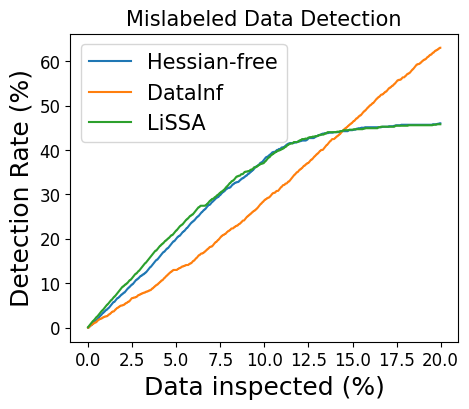

In [21]:
plt.figure(figsize=(5,4))
for method in influence_engine.IF_dict:
    detection_rate_list=[]
    low_quality_to_high_quality=np.argsort(influence_engine.IF_dict[method])[::-1]
    for ind in range(1, len(noise_index)+1):
        detected_samples = set(low_quality_to_high_quality[:ind]).intersection(noise_index)
        detection_rate = 100*len(detected_samples)/len(noise_index)
        detection_rate_list.append(detection_rate)
    plt.plot(100*np.arange(len(noise_index))/n_train, 
             detection_rate_list,
             label=method_dict[method])
plt.xlabel('Data inspected (%)', fontsize=18)
plt.ylabel('Detection Rate (%)', fontsize=18)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.legend(fontsize=15)
plt.title('Mislabeled Data Detection', fontsize=15)
plt.show()

In [22]:
for method in influence_engine.IF_dict:
    low_quality_to_high_quality=np.argsort(influence_engine.IF_dict[method])[::-1]
    print(method)
    print(low_quality_to_high_quality[0:30])

identity
[1583 3463 2794 3996 1699  320  487 4198 3374  862 1035 3515 3693 2370
  749 4141 3248  639  518 4404 2091 2462 3994  229 2229 3189 2438 2736
 3460 3424]
proposed
[1990  518 2794 1583 3996 3076 3248  134 1062 4005 2512 2736 2348 4022
  146 1693 1699  862 3463 2370   23  454 3905 3375 3506 2558 3690 2988
 3725 3374]
LiSSA
[2438  229 3693 3189 4056  526 3403 3230 3569 1425 3887   48  487 3424
 2100  290 2202   26  639 1113 4404 3751  393  320 1732 4264 2671 3063
 2969 4426]


In [23]:
vals=np.argsort(influence_engine.IF_dict['identity'])[::-1]
identity_skip_set=set(vals[0:1350])
vals=np.argsort(influence_engine.IF_dict['proposed'])[::-1]
proposed_skip_set=set(vals[0:1350])
vals=np.argsort(influence_engine.IF_dict['proposed'])[::-1]
lissa_skip_set=set(vals[0:1350])

In [26]:
from torch.utils.data import DataLoader, Dataset, Subset

In [28]:
len(eval_dataloader)

16

In [ ]:
valid_indices = [i for i in range(len(train_dataloader)) if i not in identity_skip_set]
valid_indices = [i for i in range(len(train_dataloader)) if i not in proposed_skip_set]
valid_indices = [i for i in range(len(train_dataloader)) if i not in lissa_skip_set]

In [44]:
influence_engine.IF_dict['identity'][0]


37.155914306640625

In [33]:
abs_vals=[abs(x) for x in influence_engine.IF_dict['identity']]

In [34]:
np.sort(influence_engine.IF_dict['identity'])[::-1]

array([ 88.06451416,  75.77078247,  74.69715881, ..., -36.75038528,
       -41.75810242, -76.03666687])

In [35]:
np.sort(influence_engine.IF_dict['LiSSA'])[::-1][:2]

array([1.56982240e+21, 1.56807866e+21])

In [36]:
for method in influence_engine.IF_dict:
    detection_rate_list=[]
    low_quality_to_high_quality=np.argsort(influence_engine.IF_dict[method])[::-1]
    for ind in range(1, len(noise_index)+1):
        detected_samples = set(low_quality_to_high_quality[:ind]).intersection(noise_index)
        detection_rate = 100*len(detected_samples)/len(noise_index)
        detection_rate_list.append(detection_rate)

In [37]:
low_quality_to_high_quality[:4]

array([1578, 1506, 1544,   40])

In [38]:
influence_engine.IF_dict['identity'][715]

-15.054435729980469

In [39]:
np.argsort(influence_engine.IF_dict['identity'])

array([2844,  908, 3537, ..., 3577, 1440,   40])

In [40]:
low_quality_to_high_quality

array([1578, 1506, 1544, ...,  247, 2479, 3537])